In [1]:
# manipulacja danymi
import numpy as np
import pandas as pd

# wizualizacja
import matplotlib.pyplot as plt
import seaborn as sns

# podział danych na zbiory treningowe/walidacyjne/testowe
from sklearn.model_selection import train_test_split, GridSearchCV

# budowa Pipeline
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, PowerTransformer

# redukcja wymiarowości
from sklearn.decomposition import PCA

# model
from sklearn.linear_model import LogisticRegression

# ewaluacja
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, f1_score, roc_auc_score

In [2]:
# pobrnie danych
dataset = pd.read_csv('diabetes.csv')
dataset

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0
...,...,...,...,...,...,...,...,...,...,...
14995,1490300,10,65,60,46,177,33.512468,0.148327,41,1
14996,1744410,2,73,66,27,168,30.132636,0.862252,38,1
14997,1742742,0,93,89,43,57,18.690683,0.427049,24,0
14998,1099353,0,132,98,18,161,19.791645,0.302257,23,0


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PatientID               15000 non-null  int64  
 1   Pregnancies             15000 non-null  int64  
 2   PlasmaGlucose           15000 non-null  int64  
 3   DiastolicBloodPressure  15000 non-null  int64  
 4   TricepsThickness        15000 non-null  int64  
 5   SerumInsulin            15000 non-null  int64  
 6   BMI                     15000 non-null  float64
 7   DiabetesPedigree        15000 non-null  float64
 8   Age                     15000 non-null  int64  
 9   Diabetic                15000 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 1.1 MB


tylko cechy numeryczne (brak kategorycznych)

In [4]:
X = dataset.drop(['Diabetic'], axis=1).copy()
y = dataset['Diabetic'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

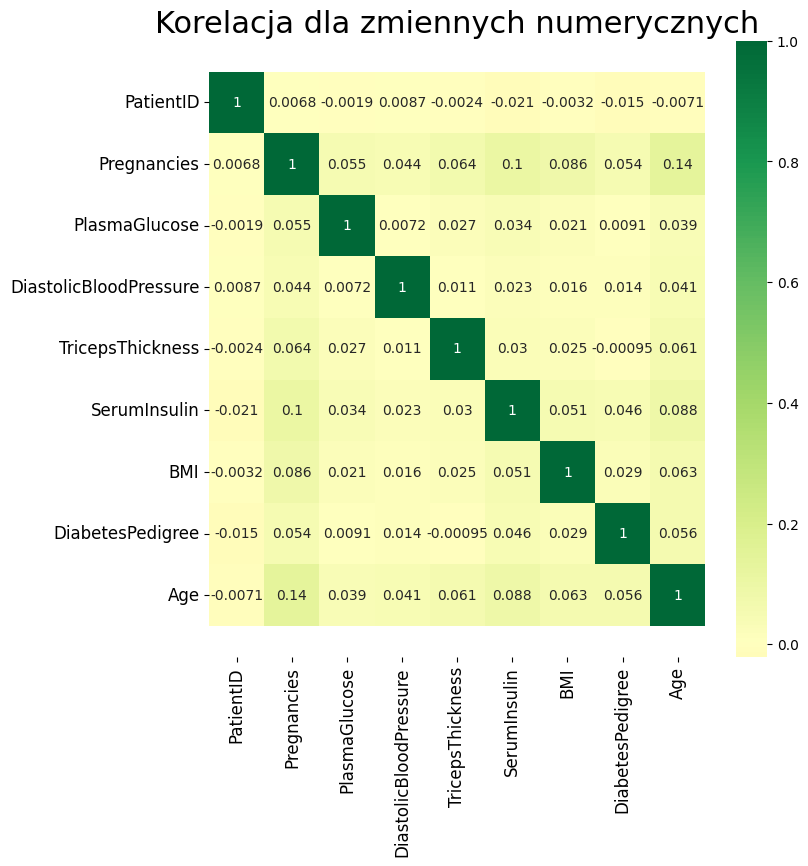

In [5]:
plt.figure(figsize=(8, 8))
ax = sns.heatmap(X.corr(),
                 xticklabels=X.corr().columns,
                 yticklabels=X.corr().columns,
                 cmap='RdYlGn',
                 center=0,
                 annot=True)

plt.title('Korelacja dla zmiennych numerycznych', fontsize=22)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [6]:
features = ['Pregnancies','PlasmaGlucose','DiastolicBloodPressure','TricepsThickness','SerumInsulin','BMI','DiabetesPedigree','Age']

In [7]:
from scipy import stats

corr_dict = {}
for col in features:
    corr_dict[col] = stats.pointbiserialr(X[col], y)[0]
pd.Series(corr_dict).sort_values(ascending=False)

Pregnancies               0.407315
Age                       0.342605
SerumInsulin              0.247375
BMI                       0.210508
DiabetesPedigree          0.170302
TricepsThickness          0.152505
PlasmaGlucose             0.128004
DiastolicBloodPressure    0.091307
dtype: float64

In [8]:
# wybór cech (można wziąć wszystkie zależnie od oecny)
num_features = ['Pregnancies', 'Age', 'SerumInsulin', 'BMI', 'DiabetesPedigree', 'TricepsThickness' ]

In [9]:
# przygotowanie wartości numerycznych 
num_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='mean'))
])

In [10]:
print('Surowy zbiór danych - zbiór treningowy:')
print(X_train[num_features].isnull().mean())
X_train_trasnformed = num_preparation.fit_transform(X_train[num_features])
X_train_trasnformed = pd.DataFrame(X_train_trasnformed, columns=num_features)
print('\nWyjście Pipeline - zbiór treningowy')
print(X_train_trasnformed[num_features].isnull().mean())

Surowy zbiór danych - zbiór treningowy:
Pregnancies         0.0
Age                 0.0
SerumInsulin        0.0
BMI                 0.0
DiabetesPedigree    0.0
TricepsThickness    0.0
dtype: float64

Wyjście Pipeline - zbiór treningowy
Pregnancies         0.0
Age                 0.0
SerumInsulin        0.0
BMI                 0.0
DiabetesPedigree    0.0
TricepsThickness    0.0
dtype: float64


In [11]:
print('Surowy zbiór danych - zbiór testowy:')
print(X_test[num_features].isnull().mean())
X_test_trasnformed = num_preparation.transform(X_test[num_features])
X_test_trasnformed = pd.DataFrame(X_test_trasnformed, columns=num_features)
print('\nWyjście Pipeline - zbiór testowy')
print(X_test_trasnformed[num_features].isnull().mean())

Surowy zbiór danych - zbiór testowy:
Pregnancies         0.0
Age                 0.0
SerumInsulin        0.0
BMI                 0.0
DiabetesPedigree    0.0
TricepsThickness    0.0
dtype: float64

Wyjście Pipeline - zbiór testowy
Pregnancies         0.0
Age                 0.0
SerumInsulin        0.0
BMI                 0.0
DiabetesPedigree    0.0
TricepsThickness    0.0
dtype: float64


In [12]:
# transformer = wartości numeryczne (brak kategorycznych)
data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features)
])

In [13]:
data_preparation.fit_transform(X_train)

array([[ 10.        ,  21.        ,  66.        ,  23.62555456,
          0.17950097,  45.        ],
       [  8.        ,  21.        ,  55.        ,  35.79832502,
          0.20387218,  11.        ],
       [  1.        ,  22.        ,  42.        ,  18.66643392,
          0.15914937,  41.        ],
       ...,
       [  0.        ,  23.        , 156.        ,  38.6410823 ,
          0.24041813,  33.        ],
       [  1.        ,  23.        ,  65.        ,  36.38418629,
          0.70256866,  15.        ],
       [  1.        ,  22.        ,  34.        ,  21.08530082,
          0.17077794,  34.        ]])

In [14]:
data_preparation.fit_transform(X_train).shape

(11250, 6)

In [15]:
num_features = ['Pregnancies', 'Age', 'SerumInsulin', 'BMI', 'DiabetesPedigree', 'TricepsThickness' ]

# przygotowanie wartości numerycznych
num_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='mean'))
])


# transformer = wartości numeryczne oraz kategoryczne
data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features)
])

model_pipeline_v1 = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(max_iter=10000))])

In [16]:
model_pipeline_v1.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_preprocessing',
                                                  Pipeline(steps=[('fill_missings',
                                                                   SimpleImputer())]),
                                                  ['Pregnancies', 'Age',
                                                   'SerumInsulin', 'BMI',
                                                   'DiabetesPedigree',
                                                   'TricepsThickness'])])),
                ('model', LogisticRegression(max_iter=10000))])

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      2500
           1       0.70      0.58      0.64      1250

    accuracy                           0.78      3750
   macro avg       0.76      0.73      0.74      3750
weighted avg       0.77      0.78      0.77      3750



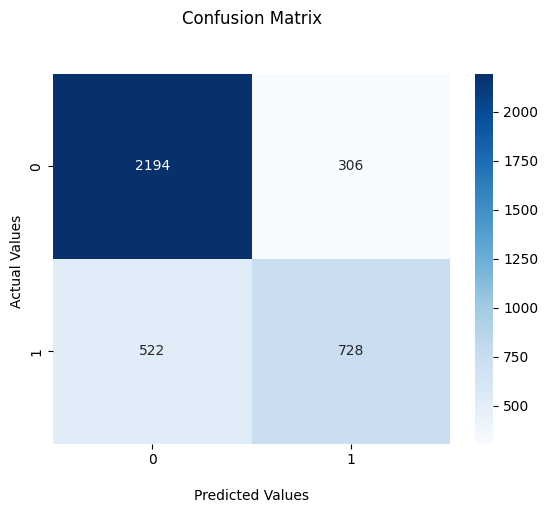

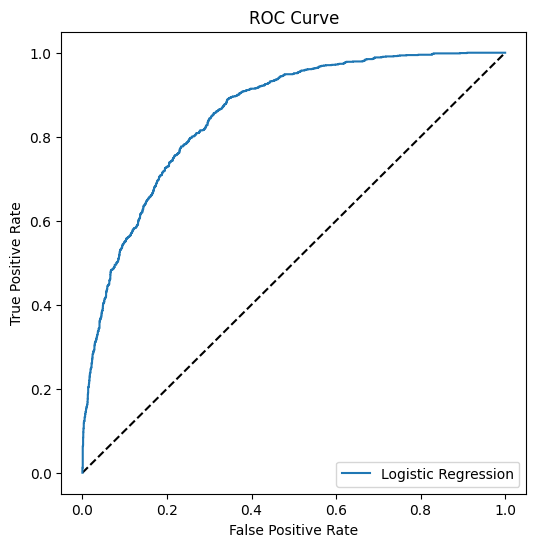

C:\Users\Kasia\AppData\Local\Temp\ipykernel_9536\3521459594.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_dataframe = pd.concat([metrics_dataframe, pd.DataFrame([{'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric}])], ignore_index=True)


,Model,F1_score,AUC
0,Logistic Regression,0.637478,0.854781


In [17]:
metrics_dataframe = pd.DataFrame(columns = ['Model', 'F1_score', 'AUC'])
metrics_dataframe
models = []
models_names = []
predictions_proba_list = []

def calculate_metrics(model, name, X_checked, y_checked):
    models.append(model)
    models_names.append(name)
    global metrics_dataframe
    predictions = model.predict(X_checked)
    predictions_proba = model.predict_proba(X_checked)
    predictions_proba_list.append(predictions_proba[:,1])

    ############## metryki dla sprawdzanego modelu ################

    # Precision, Recall, F1, Accuracy
    print(classification_report(y_checked, predictions))

    # Confusion matrix
    plt.figure()
    cm = confusion_matrix(y_checked, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()

    # plot ROC curve
    fig = plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    for model_selected, name_selected, pred_proba in zip(models, models_names, predictions_proba_list):
        fpr, tpr, thresholds = roc_curve(y_checked, pred_proba)
        plt.plot(fpr, tpr, label=name_selected)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    f1_metric = f1_score(y_checked, predictions)
    auc_metric = roc_auc_score(y_checked, predictions_proba[:,1])
    metrics_dataframe = pd.concat([metrics_dataframe, pd.DataFrame([{'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric}])], ignore_index=True)
    return metrics_dataframe

calculate_metrics(model_pipeline_v1, 'Logistic Regression', X_test, y_test)

In [18]:
# z uwzględnieniem charakterystyki regresji logistycznej (wielomian, standaryzacja, pca)

# przygotowanie wartości numerycznych
num_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='mean')),
    ('polynomial_features', PolynomialFeatures(degree=3)),
    ('scaler_1', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('scaler_2', StandardScaler())
])


# transformer = wartości numeryczne oraz kategoryczne
data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features)
])

model_pipeline_v2 = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(max_iter=10000))])
model_pipeline_v2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_preprocessing',
                                                  Pipeline(steps=[('fill_missings',
                                                                   SimpleImputer()),
                                                                  ('polynomial_features',
                                                                   PolynomialFeatures(degree=3)),
                                                                  ('scaler_1',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.95)),
                                                                  ('scaler_2',
                                                                   StandardScaler())]),
                                                  ['Pregnancies', 'Age',
                                                   'SerumInsulin', 'BMI',
                                                   'DiabetesPedigree',
                                                   'TricepsThickness'])])),
                ('model', LogisticRegression(max_iter=10000))])

              precision    recall  f1-score   support

           0       0.80      0.91      0.85      2500
           1       0.75      0.54      0.63      1250

    accuracy                           0.79      3750
   macro avg       0.77      0.72      0.74      3750
weighted avg       0.78      0.79      0.77      3750



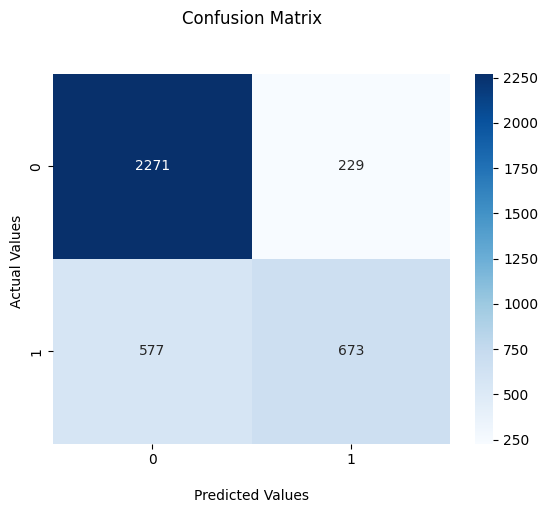

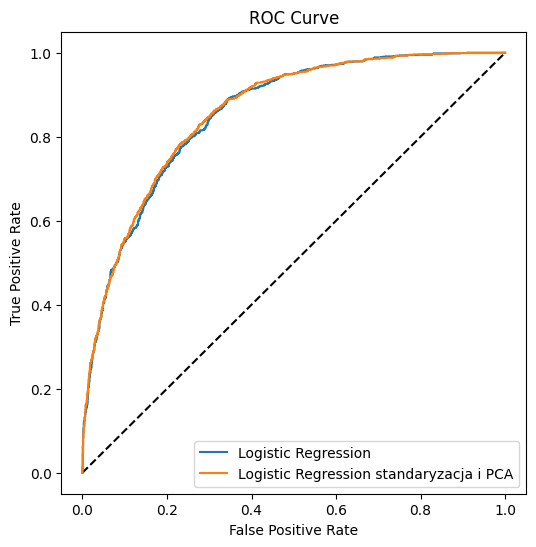

,Model,F1_score,AUC
0,Logistic Regression,0.637478,0.854781
1,Logistic Regression standaryzacja i PCA,0.625465,0.857796


In [19]:
calculate_metrics(model_pipeline_v2, 'Logistic Regression standaryzacja i PCA', X_test, y_test)

In [20]:
model_pipeline_v3 = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(max_iter=10000))])

poszukiwanie parametrów

In [21]:
list(model_pipeline_v3.get_params().keys())

['memory',
 'steps',
 'verbose',
 'preprocessor',
 'model',
 'preprocessor__force_int_remainder_cols',
 'preprocessor__n_jobs',
 'preprocessor__remainder',
 'preprocessor__sparse_threshold',
 'preprocessor__transformer_weights',
 'preprocessor__transformers',
 'preprocessor__verbose',
 'preprocessor__verbose_feature_names_out',
 'preprocessor__numeric_preprocessing',
 'preprocessor__numeric_preprocessing__memory',
 'preprocessor__numeric_preprocessing__steps',
 'preprocessor__numeric_preprocessing__verbose',
 'preprocessor__numeric_preprocessing__fill_missings',
 'preprocessor__numeric_preprocessing__polynomial_features',
 'preprocessor__numeric_preprocessing__scaler_1',
 'preprocessor__numeric_preprocessing__pca',
 'preprocessor__numeric_preprocessing__scaler_2',
 'preprocessor__numeric_preprocessing__fill_missings__add_indicator',
 'preprocessor__numeric_preprocessing__fill_missings__copy',
 'preprocessor__numeric_preprocessing__fill_missings__fill_value',
 'preprocessor__numeric_pre

In [22]:
params = {
    'preprocessor__numeric_preprocessing__fill_missings__strategy': ['mean', 'median'],
    'preprocessor__numeric_preprocessing__polynomial_features__degree': [1, 2, 3, 4],
    'preprocessor__numeric_preprocessing__pca__n_components': [0.85, 0.90, 0.95, 0.99, 0.99999],
    'model__C': np.logspace(-4, 4, 50)
}

grid_search = GridSearchCV(model_pipeline_v3, params, cv=10, n_jobs=-1, verbose=10, scoring='f1_macro')
grid_search.fit(X_train, y_train)
print('Wybrane hiperparametry: ', grid_search.best_params_)
model_v3 = grid_search.best_estimator_

Fitting 10 folds for each of 2000 candidates, totalling 20000 fits
Wybrane hiperparametry:  {'model__C': 24.420530945486497, 'preprocessor__numeric_preprocessing__fill_missings__strategy': 'mean', 'preprocessor__numeric_preprocessing__pca__n_components': 0.99999, 'preprocessor__numeric_preprocessing__polynomial_features__degree': 4}


              precision    recall  f1-score   support

           0       0.91      0.92      0.92      2500
           1       0.84      0.83      0.84      1250

    accuracy                           0.89      3750
   macro avg       0.88      0.88      0.88      3750
weighted avg       0.89      0.89      0.89      3750



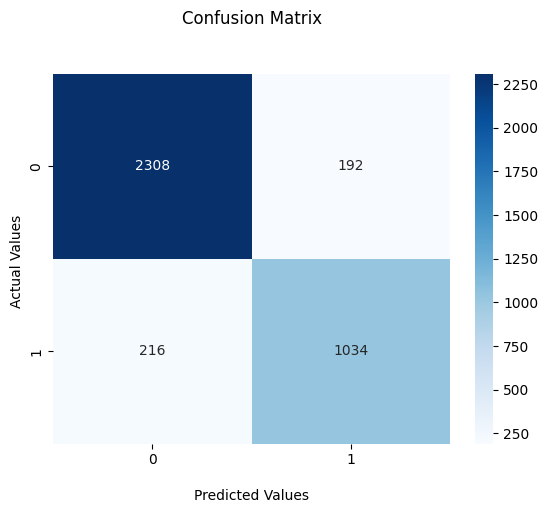

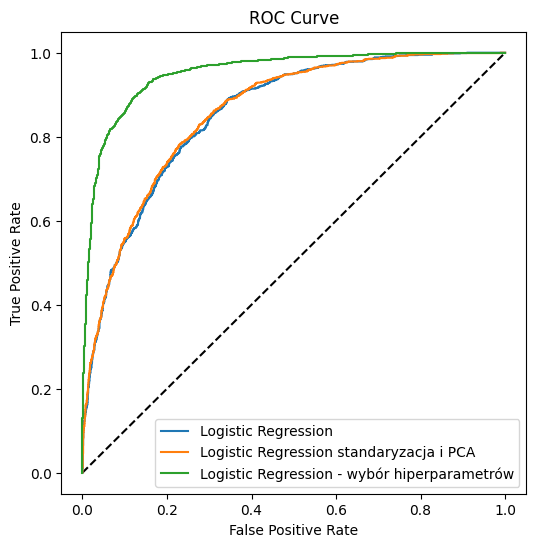

,Model,F1_score,AUC
0,Logistic Regression,0.637478,0.854781
1,Logistic Regression standaryzacja i PCA,0.625465,0.857796
2,Logistic Regression - wybór hiperparametrów,0.835218,0.951980


In [23]:
calculate_metrics(model_v3, 'Logistic Regression - wybór hiperparametrów', X_test, y_test)

W porównaniu z wynikami z wcześniejszego modułu (https://github.com/kstrzelinska/Modul14_zad1/blob/master/zad1.ipynb):
                                     Model  F1_score       AUC
0  Logistic Regression (No Regularization)  0.580928  0.816493
1  Logistic Regression (L1 Regularization)  0.567175  0.816049
2  Logistic Regression (L2 Regularization)  0.506095  0.816606
3         Logistic Regression (elasticnet)  0.580928  0.816493

wynik z /Logistic Regression - wybór hiperparametrów/ wydaje się być najlepszy (najwyższe F1_score i AUC)